In [845]:
import collections
import itertools as it
import json
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import numpy as np
import torch
import seaborn as sns
from sklearn.linear_model import LinearRegression

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
results = collections.defaultdict(lambda: collections.defaultdict(lambda: [[], [], []]))
with open("/tmp/gridsearch_results.txt", "rt") as f:
    for i, l in enumerate(f):
        if i < 1000:
            continue  # Ignore warmup
        
        entry = json.loads(l.strip())
        impl, c_in, c_out, image_h, image_w, delta_ns = [entry[i] for i in ("choice", "c_in", "c_out", "image_h", "image_w", "delta_ns")]

        results[(image_h, image_w)][(c_in, c_out)][impl].append(delta_ns)

bounds = {
    k: [[np.inf, np.inf], [-np.inf, -np.inf]]
    for k in results
}

for k, r in results.items():
    for c_in, c_out in r:
        bounds[k][0][0] =  min(bounds[k][0][0], c_in)
        bounds[k][0][1] =  min(bounds[k][0][0], c_out)
        bounds[k][1][0] =  max(bounds[k][1][0], c_in)
        bounds[k][1][1] =  max(bounds[k][1][0], c_out)

    assert(bounds[k][0][0] >= 0)
    assert(bounds[k][0][1] >= 0)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/gridsearch_results.txt'

In [ ]:
border_map = {
    k: np.ones((bounds[k][1][0] + 2, bounds[k][1][1] + 2, 3))
    for k in results
}

# These parameters control the brightness and contrast of the image
max_scale = 1.2
offset = 0.5

for k, r in results.items():
    count = 0
    best_counts = [0, 0, 0]

    for (c_in, c_out), v in r.items():
        if all(v):
            v = np.array([np.mean(vi) for vi in v])
            v /= np.min(v)
            v -= offset
            v = max_scale / v

            best_counts[np.argmin(v)] += 1
            count += 1

            border_map[k][c_in, c_out, :] = torch.softmax(torch.Tensor(v), dim=0).numpy()

    print(count)
    print(k, best_counts)

In [3]:
fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
subplot_w = int(np.ceil(np.sqrt(len(results))))
subplot_h = int(np.ceil(len(results) / subplot_w))
for i, k in enumerate(sorted(border_map.keys())):
    bm = border_map[k]
    
    # Interpolate missing points
    bm = bm.copy()
    ind_to_interpolate = []
    for index_0 in range(1, bm.shape[0] - 1):
        for index_1 in range(1, bm.shape[1] - 1):
            if sum(bm[index_0, index_1, :]) == 3:
                ind_to_interpolate.append((index_0, index_1))
    for index_0, index_1 in ind_to_interpolate * 5:
        bm[index_0, index_1, :] = (
            bm[index_0 - 1, index_1, :] +
            bm[index_0 + 1, index_1, :] +
            bm[index_0, index_1 - 1, :] +
            bm[index_0, index_1 + 1, :]) / 4
        
    print(f"{len(ind_to_interpolate)} / {bm.shape[0] * bm.shape[1]} points interpolated")
    
    plt.subplot(subplot_h, subplot_w, i + 1)
    plt.imshow(bm, interpolation="none", origin="lower")
    plt.grid(None)
    plt.xlabel("c_out", fontsize="xx-large")
    plt.ylabel("c_in", fontsize="xx-large")
    plt.title(str(k))

patches = [mpatches.Patch(color=c, label=l) for c, l in (([1, 0, 0], "TH"), ([0, 1, 0], "NNPack"), ([0, 0, 1], "MKL"))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0. , fontsize="xx-large")
fig.tight_layout()

ZeroDivisionError: division by zero

<Figure size 960x960 with 0 Axes>

In [177]:
drilldown_results = collections.defaultdict(lambda: [[], [], []])
with open("/tmp/drilldown_results.txt", "rt") as f:
    for i, l in enumerate(f):
        if i < 1000:
            continue  # Ignore warmup
            
        entry = json.loads(l.strip())
        impl, c_in, c_out, image_h, image_w, delta_ns = [entry[i] for i in ("choice", "c_in", "c_out", "image_h", "image_w", "delta_ns")]
        assert (image_h, image_w) == (128, 128)
#         assert (image_h, image_w) == (64, 64)
        drilldown_results[(c_in, c_out)][impl].append(delta_ns)

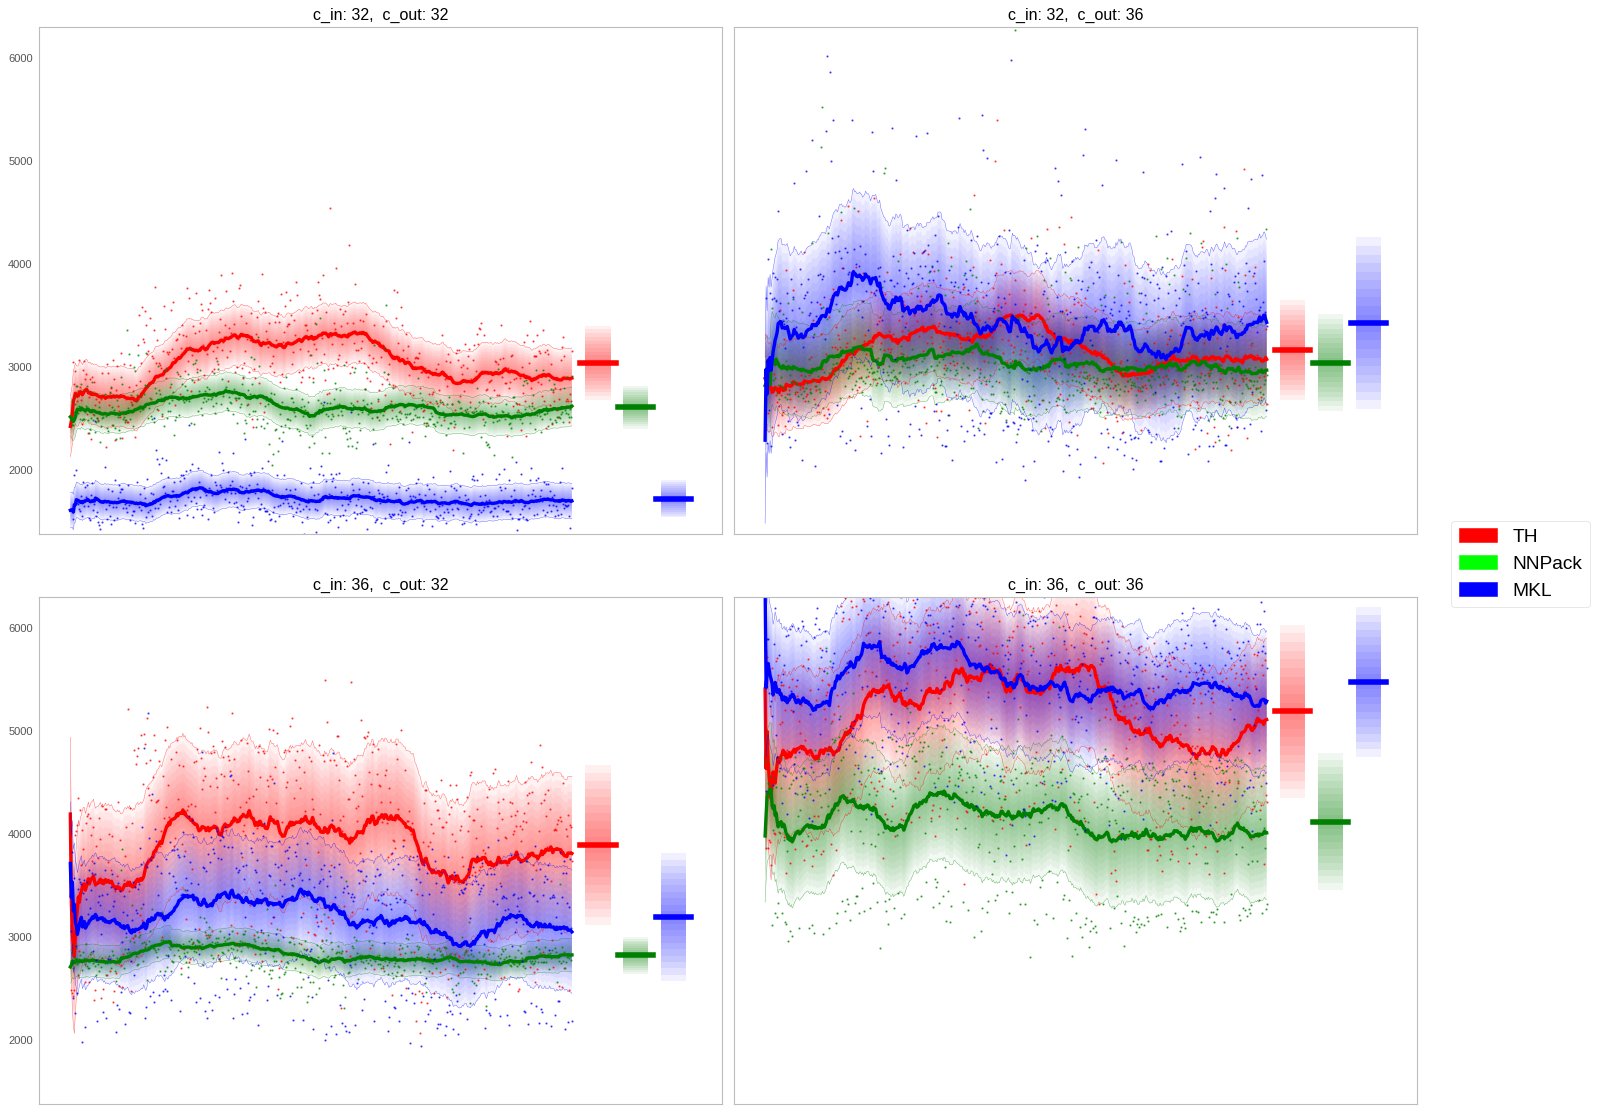

In [178]:
window = 50

n = 500
flat_values = list(it.chain(*it.chain(*drilldown_results.values())))
y_min = np.percentile(flat_values, 0.01) * 1e-3
y_max = np.percentile(flat_values, 98) * 1e-3

fig = plt.figure(figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
drilldown_keys = sorted(drilldown_results.keys())
subplot_w = int(np.ceil(np.sqrt(len(drilldown_keys))))
subplot_h = int(np.ceil(len(drilldown_keys) / subplot_w))
for drilldown_index, (c_in, c_out) in enumerate(drilldown_keys):
    plt.subplot(subplot_h, subplot_w, drilldown_index + 1)
    for j, color in enumerate(["r", "g", "b"]):
        y = np.array(drilldown_results[(c_in, c_out)][j][:n]) * 1e-3
    
        running_mean, running_std = [], []
        for i in range(len(y)):
            y_subset = y[max(0, i + 1 - window):i + 1]
            running_mean.append(np.mean(y_subset))
            running_std.append(np.std(y_subset))
        running_mean, running_std = np.array(running_mean), np.mean(running_std)
        
        plt.plot(y, "." + color, markersize=2, alpha=0.6)
        plt.plot(running_mean, color, linewidth=3)
        
        shade_k = 3
        for i in range(1, shade_k + 1):
            y_lower = running_mean - running_std * i / shade_k
            y_upper = running_mean + running_std * i / shade_k
            plt.fill_between(np.arange(n), y_lower, y_upper, facecolor=color, alpha=0.5/shade_k)
            
            plt.fill_between(
                n * 1.025 + j * n * 0.075 + np.array([0, n * 0.05]),
                [np.mean(y) - np.std(y) * i / shade_k] * 2,
                [np.mean(y) + np.std(y) * i / shade_k] * 2,
                facecolor=color,
                alpha=0.6/shade_k,
            )
        plt.plot(y_lower, "-" + color, linewidth=0.4, alpha=0.6)
        plt.plot(y_upper, "-" + color, linewidth=0.4, alpha=0.6)
        plt.plot(n * 1.025 + j * n * 0.075 + np.array([-n * 0.01, n * 0.06]), [np.mean(y)] * 2, color=color, linewidth=5)
        

    plt.title(f"c_in: {c_in},  c_out: {c_out}")
    plt.ylim(bottom=y_min, top=y_max)
    plt.grid(None)
    
    plt.gca().axes.get_xaxis().set_visible(False)
    if drilldown_index % subplot_w:
        plt.gca().axes.get_yaxis().set_visible(False)

patches = [mpatches.Patch(color=c, label=l) for c, l in (([1, 0, 0], "TH"), ([0, 1, 0], "NNPack"), ([0, 0, 1], "MKL"))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.15), loc=2, borderaxespad=0. , fontsize="xx-large")
fig.tight_layout()

In [940]:
AUTOTUNE_COLOR = "lightgreen"
NON_AUTOTUNE_COLOR = "dimgrey"

AUTOTUNE_MARKER_KWARGS = {
    "color": AUTOTUNE_COLOR,
    "markeredgecolor": "darkgreen"
}

NON_AUTOTUNE_MARKER_KWARGS = {
    "color": NON_AUTOTUNE_COLOR,
    "markeredgecolor": "k"
}

In [941]:
torchvision_trials = []
with open("/tmp/torchvision_results.txt", "rt") as f:
    for l in f:
        trial = json.loads(l.strip())
        torchvision_trials.append(trial)

for key, y in torchvision_trials:
    y["delta"] = np.mean(y["on"]) / np.mean(y["off"]) - 1.0
    
torchvision_trials.sort(key=lambda x: -x[1]["delta"])

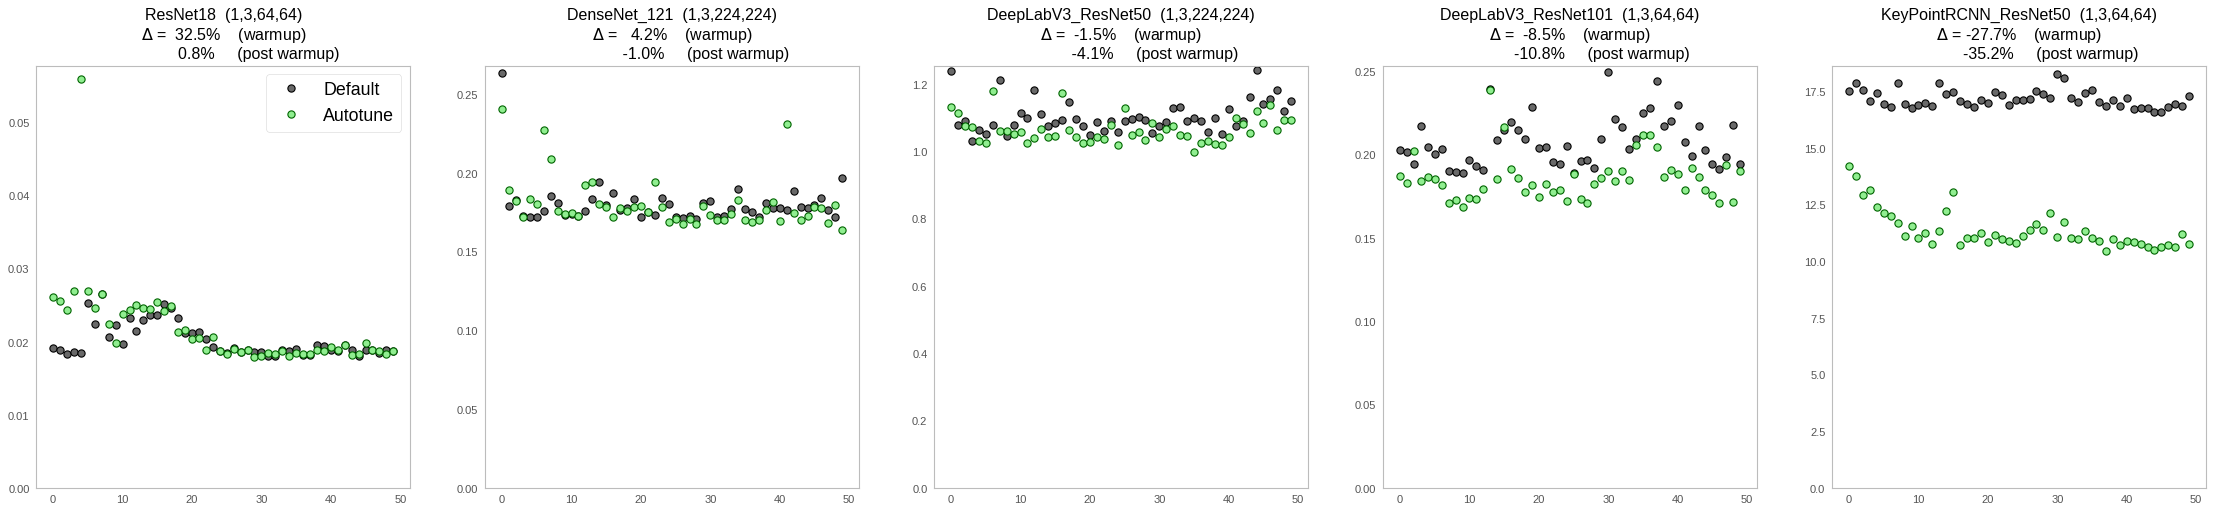

In [942]:
n = 5
fig = plt.figure(figsize=(7 * n, 7), dpi=80, facecolor='w', edgecolor='k')
for i, index in enumerate([int(ind) for ind in np.linspace(0, len(torchvision_trials) - 1, n)]):
    ax = plt.subplot(1, n, i + 1)
    ax.grid(False)
    (model, size), y = torchvision_trials[index]
    warmup_delta =  np.mean(y["on"][:10]) / np.mean(y["off"][:10]) - 1.0
    post_warmup_delta =  np.mean(y["on"][10:]) / np.mean(y["off"][10:]) - 1.0
    plt.plot(y["off"], ".", markersize=13, **NON_AUTOTUNE_MARKER_KWARGS)
    plt.plot(y["on"], ".", markersize=13, **AUTOTUNE_MARKER_KWARGS)
    plt.ylim(bottom=0)
    plt.title(
        f"{model}  ({size})\n"
        f"$\Delta$ = {warmup_delta * 100:>5.1f}%    (warmup)\n"
        f"{'':>14}{post_warmup_delta * 100:>5.1f}%     (post warmup)",
    )
    if not i:
        plt.legend(["Default", "Autotune"], fontsize=16)

(-60, 60)

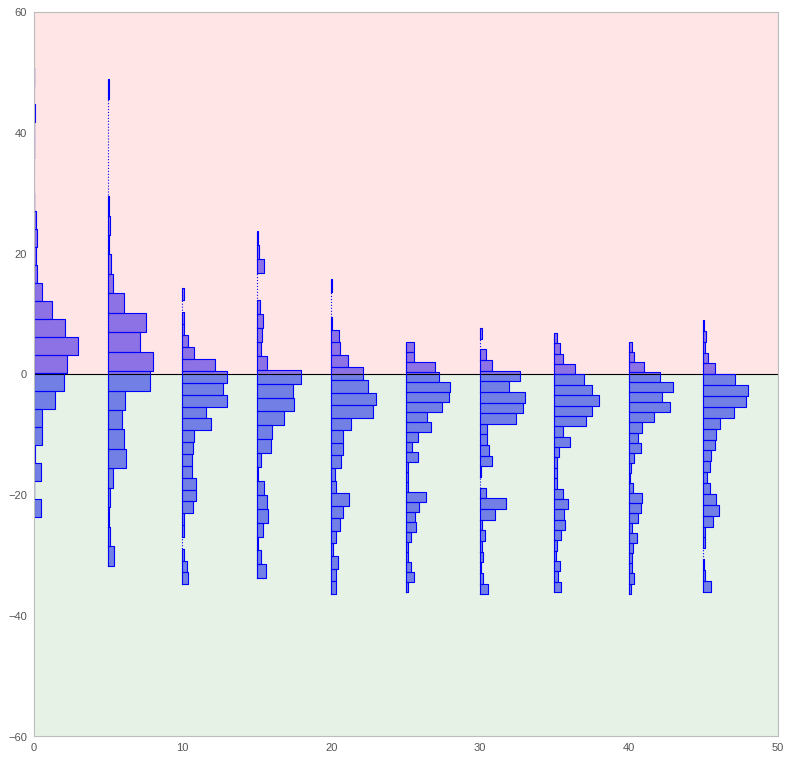

In [943]:
n_max = 45
window=5
fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot([0, n_max + 5], [0, 0], "k", linewidth=1)
plt.grid(False)

y_min, y_max = np.inf, -np.inf
for offset in range(0, n_max + 1, 5):
    deltas = []
    for _, y in torchvision_trials:
        delta = np.mean(y["on"][offset:offset+window]) / np.mean(y["off"][offset:offset+10]) - 1.0
        deltas.append(delta * 100)
    x, y = np.histogram(deltas, bins=25, density=True)
    x = x / np.max(x) * 3
    x += offset
    for i, xi in enumerate(x):
        if xi <= offset:
            continue
        plt.fill_between(
            [offset, xi],
            [y[i]] * 2, 
            [y[i+1]] * 2,
            facecolor="b",
            alpha=0.5
        )
        plt.plot(
            [offset] + [xi] * 2 +  [offset] * 2,
            [y[i]] * 2 + [y[i+1]] * 2 + [y[i]],
            "b"
        )
    plt.plot([offset] * 2, [y[0], y[-1]], ":b")
    y_min = min(y_min, np.min(y))
    y_max = max(y_max, np.max(y))
y_min = int(y_min // 10) * 10
y_max = int(np.ceil(y_max / 10)) * 10
fill_y = max(abs(y_min), abs(y_max))
plt.fill_between([0, n_max + 5], [0, 0], [-fill_y, -fill_y], facecolor="g", alpha=0.1)
plt.fill_between([0, n_max + 5], [0, 0], [fill_y, fill_y], facecolor="r", alpha=0.1)
plt.xlim(0, n_max + 5)
plt.ylim(-fill_y, fill_y)

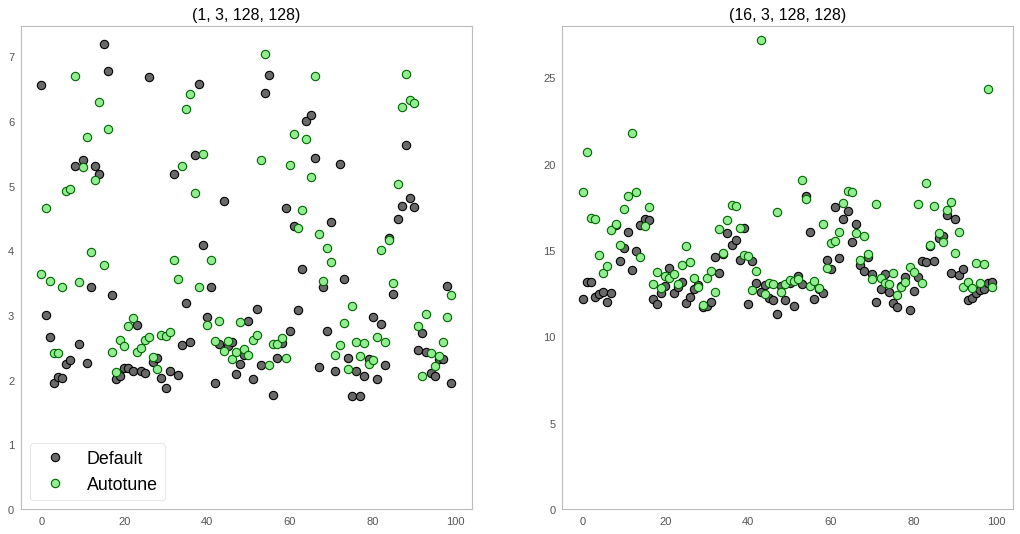

In [921]:
raw_gan_train = {(1, 3, 128, 128): [('off', 6.571912527084351), ('on', 3.6459381580352783), ('off', 3.0016443729400635), ('on', 4.660109519958496), ('off', 2.667090654373169), ('on', 3.5312910079956055), ('off', 1.9604392051696777), ('on', 2.418959140777588), ('off', 2.053548812866211), ('on', 2.4236464500427246), ('off', 2.029547929763794), ('on', 3.4472391605377197), ('off', 2.2526540756225586), ('on', 4.919529914855957), ('off', 2.317108392715454), ('on', 4.9514875411987305), ('off', 5.318604469299316), ('on', 6.7107789516448975), ('off', 2.561880111694336), ('on', 3.52069354057312), ('off', 5.408689737319946), ('on', 5.302578926086426), ('off', 2.2661149501800537), ('on', 5.762307405471802), ('off', 3.4348459243774414), ('on', 3.979532480239868), ('off', 5.306207895278931), ('on', 5.098188400268555), ('off', 5.180257320404053), ('on', 6.302614688873291), ('off', 7.203174352645874), ('on', 3.787487268447876), ('off', 6.786790132522583), ('on', 5.8801658153533936), ('off', 3.3111226558685303), ('on', 2.434936285018921), ('off', 2.0136466026306152), ('on', 2.127901792526245), ('off', 2.05511736869812), ('on', 2.6202962398529053), ('off', 2.192960023880005), ('on', 2.5323684215545654), ('off', 2.193706750869751), ('on', 2.829930305480957), ('off', 2.1436023712158203), ('on', 2.955120086669922), ('off', 2.8471322059631348), ('on', 2.435272455215454), ('off', 2.1463613510131836), ('on', 2.5008862018585205), ('off', 2.1166698932647705), ('on', 2.6243910789489746), ('off', 6.695216417312622), ('on', 2.668402671813965), ('off', 2.2789080142974854), ('on', 2.349290609359741), ('off', 2.33927321434021), ('on', 2.1756043434143066), ('off', 2.029567241668701), ('on', 2.6970860958099365), ('off', 1.8791699409484863), ('on', 2.68038272857666), ('off', 2.1401686668395996), ('on', 2.7491188049316406), ('off', 5.188073396682739), ('on', 3.860661745071411), ('off', 2.080900192260742), ('on', 3.5607364177703857), ('off', 2.546372413635254), ('on', 5.309826135635376), ('off', 3.193812847137451), ('on', 6.191754579544067), ('off', 2.585594892501831), ('on', 6.430708408355713), ('off', 5.48134970664978), ('on', 4.901487350463867), ('off', 6.5788352489471436), ('on', 3.434255838394165), ('off', 4.0820534229278564), ('on', 5.498734712600708), ('off', 2.9762868881225586), ('on', 2.857485771179199), ('off', 3.436262369155884), ('on', 3.856752395629883), ('off', 1.9580304622650146), ('on', 2.6028754711151123), ('off', 2.5644643306732178), ('on', 2.911897897720337), ('off', 4.76575493812561), ('on', 2.4551243782043457), ('off', 2.524449586868286), ('on', 2.5973963737487793), ('off', 2.5813260078430176), ('on', 2.329324245452881), ('off', 2.09200382232666), ('on', 2.4357261657714844), ('off', 2.24592661857605), ('on', 2.898425817489624), ('off', 2.381828784942627), ('on', 2.4763143062591553), ('off', 2.913823366165161), ('on', 2.382686138153076), ('off', 2.0221526622772217), ('on', 2.6163742542266846), ('off', 3.0965495109558105), ('on', 2.7035343647003174), ('off', 2.2391505241394043), ('on', 5.408829212188721), ('off', 6.434901237487793), ('on', 7.037482023239136), ('off', 6.721656799316406), ('on', 2.237924814224243), ('off', 1.761481523513794), ('on', 2.5602853298187256), ('off', 2.3336169719696045), ('on', 2.5612311363220215), ('off', 2.5730953216552734), ('on', 2.6468136310577393), ('off', 4.656912803649902), ('on', 2.333699941635132), ('off', 2.7597622871398926), ('on', 5.320166110992432), ('off', 4.3855509757995605), ('on', 5.800135374069214), ('off', 3.0813214778900146), ('on', 4.346567153930664), ('off', 3.722383499145508), ('on', 4.6273274421691895), ('off', 6.014225721359253), ('on', 5.7301483154296875), ('off', 6.104792594909668), ('on', 5.137411117553711), ('off', 5.438302278518677), ('on', 6.7035300731658936), ('off', 2.1992318630218506), ('on', 4.252694606781006), ('off', 3.440371036529541), ('on', 3.5349204540252686), ('off', 2.766328811645508), ('on', 4.038378953933716), ('off', 4.442370891571045), ('on', 3.8197808265686035), ('off', 2.1402039527893066), ('on', 2.389359951019287), ('off', 5.336620092391968), ('on', 2.5421595573425293), ('off', 3.562072992324829), ('on', 2.8802638053894043), ('off', 2.343587636947632), ('on', 2.1677017211914062), ('off', 1.7585670948028564), ('on', 3.15199613571167), ('off', 2.144615411758423), ('on', 2.5919172763824463), ('off', 1.754220962524414), ('on', 2.367528200149536), ('off', 2.0597612857818604), ('on', 2.574073076248169), ('off', 2.329806327819824), ('on', 2.241124153137207), ('off', 2.9744627475738525), ('on', 2.3178634643554688), ('off', 2.0113613605499268), ('on', 2.6703479290008545), ('off', 2.8741698265075684), ('on', 4.008907079696655), ('off', 2.227675199508667), ('on', 2.5920488834381104), ('off', 4.1914222240448), ('on', 4.1694440841674805), ('off', 3.327787399291992), ('on', 3.5063650608062744), ('off', 4.486840724945068), ('on', 5.029011011123657), ('off', 4.69000506401062), ('on', 6.224518060684204), ('off', 5.630551815032959), ('on', 6.733127593994141), ('off', 4.817927122116089), ('on', 6.339494228363037), ('off', 4.680176734924316), ('on', 6.291795015335083), ('off', 2.465317726135254), ('on', 2.8342602252960205), ('off', 2.7245376110076904), ('on', 2.062781572341919), ('off', 2.436511516571045), ('on', 3.0216243267059326), ('off', 2.103073835372925), ('on', 2.4141502380371094), ('off', 2.061601400375366), ('on', 2.2200543880462646), ('off', 2.3188416957855225), ('on', 2.374668836593628), ('off', 2.3324074745178223), ('on', 2.593587636947632), ('off', 3.45062255859375), ('on', 2.97166109085083), ('off', 1.960667371749878), ('on', 3.3215343952178955)], (16, 3, 128, 128): [('off', 12.205896854400635), ('on', 18.41199016571045), ('off', 13.174330472946167), ('on', 20.728052139282227), ('off', 13.1642484664917), ('on', 16.881052017211914), ('off', 12.325431108474731), ('on', 16.81584620475769), ('off', 12.490015745162964), ('on', 14.720074892044067), ('off', 12.61395001411438), ('on', 13.711089372634888), ('off', 12.004642963409424), ('on', 14.097470045089722), ('off', 12.514472246170044), ('on', 16.168936491012573), ('off', 16.489803552627563), ('on', 16.5427668094635), ('off', 14.358388662338257), ('on', 15.327088356018066), ('off', 15.14751410484314), ('on', 17.422462463378906), ('off', 16.05366849899292), ('on', 18.169844150543213), ('off', 13.873952150344849), ('on', 21.80718231201172), ('off', 14.971784353256226), ('on', 18.357916116714478), ('off', 16.443488121032715), ('on', 14.628204107284546), ('off', 16.837467432022095), ('on', 16.404247045516968), ('off', 16.742159128189087), ('on', 17.539490938186646), ('off', 12.170177459716797), ('on', 13.060832023620605), ('off', 11.870333909988403), ('on', 13.76700496673584), ('off', 12.536983728408813), ('on', 12.794727563858032), ('off', 12.940062284469604), ('on', 13.510438203811646), ('off', 13.988020181655884), ('on', 13.400162935256958), ('off', 12.553487777709961), ('on', 13.611346244812012), ('off', 12.879533529281616), ('on', 13.073129177093506), ('off', 13.166563749313354), ('on', 14.12929081916809), ('off', 11.937327146530151), ('on', 15.282976150512695), ('off', 12.325944185256958), ('on', 14.35192346572876), ('off', 12.777915239334106), ('on', 13.395302295684814), ('off', 13.001548528671265), ('on', 12.882083177566528), ('off', 11.692761898040771), ('on', 11.852168798446655), ('off', 11.798762321472168), ('on', 13.383252382278442), ('off', 12.008891344070435), ('on', 13.825649976730347), ('off', 14.626352310180664), ('on', 12.61298155784607), ('off', 13.681270599365234), ('on', 16.256781339645386), ('off', 14.795605421066284), ('on', 14.86834716796875), ('off', 16.02970790863037), ('on', 16.772565126419067), ('off', 15.328580856323242), ('on', 17.651732444763184), ('off', 15.585654020309448), ('on', 17.563894271850586), ('off', 14.420261859893799), ('on', 16.27465510368347), ('off', 16.290444135665894), ('on', 14.730008125305176), ('off', 11.90754222869873), ('on', 14.665384531021118), ('off', 14.406105518341064), ('on', 12.696040868759155), ('off', 13.104548215866089), ('on', 13.8266019821167), ('off', 12.61496639251709), ('on', 27.198583364486694), ('off', 12.980971097946167), ('on', 12.450956344604492), ('off', 12.235284328460693), ('on', 13.111003637313843), ('off', 12.100228071212769), ('on', 13.076386451721191), ('off', 11.331109285354614), ('on', 17.225529193878174), ('off', 12.946599960327148), ('on', 12.584472894668579), ('off', 12.118948221206665), ('on', 13.027772188186646), ('off', 13.098488092422485), ('on', 13.262018203735352), ('off', 11.795697689056396), ('on', 13.20759129524231), ('off', 13.527116060256958), ('on', 13.339955568313599), ('off', 13.053800106048584), ('on', 19.090237855911255), ('off', 18.1698899269104), ('on', 17.987680673599243), ('off', 16.05505633354187), ('on', 12.91092324256897), ('off', 12.210932493209839), ('on', 13.213977813720703), ('off', 12.756091594696045), ('on', 12.84201455116272), ('off', 12.513813734054565), ('on', 16.537274837493896), ('off', 14.431923866271973), ('on', 13.975046157836914), ('off', 13.933655261993408), ('on', 15.444302082061768), ('off', 17.54149079322815), ('on', 15.55417275428772), ('off', 14.58609127998352), ('on', 16.050504207611084), ('off', 16.82090973854065), ('on', 17.763027906417847), ('off', 17.311479568481445), ('on', 18.417294025421143), ('off', 15.470375776290894), ('on', 18.365727186203003), ('off', 16.536744117736816), ('on', 16.01123356819153), ('off', 14.17883825302124), ('on', 14.471048831939697), ('off', 13.815396308898926), ('on', 15.809303760528564), ('off', 14.59203028678894), ('on', 14.772950172424316), ('off', 13.655616283416748), ('on', 13.323525428771973), ('off', 12.004323720932007), ('on', 17.707443237304688), ('off', 12.785866737365723), ('on', 13.404547214508057), ('off', 13.63467812538147), ('on', 13.090816736221313), ('off', 12.576567649841309), ('on', 13.033109664916992), ('off', 11.966147661209106), ('on', 13.688698291778564), ('off', 11.699996948242188), ('on', 12.421267986297607), ('off', 12.944437503814697), ('on', 12.898528337478638), ('off', 13.433911561965942), ('on', 13.153296947479248), ('off', 11.545202493667603), ('on', 14.033363819122314), ('off', 12.649234533309937), ('on', 13.741626977920532), ('off', 13.434805870056152), ('on', 17.680038690567017), ('off', 14.405455827713013), ('on', 13.120071649551392), ('off', 14.305323839187622), ('on', 18.899345636367798), ('off', 15.282318830490112), ('on', 15.326122522354126), ('off', 14.388612985610962), ('on', 17.55735158920288), ('off', 15.71222734451294), ('on', 16.005221843719482), ('off', 15.832241535186768), ('on', 15.48194169998169), ('off', 17.064684629440308), ('on', 17.342480659484863), ('off', 13.71921181678772), ('on', 17.812739372253418), ('off', 16.82398009300232), ('on', 14.854300498962402), ('off', 13.580609560012817), ('on', 16.060020446777344), ('off', 13.895944356918335), ('on', 12.864485502243042), ('off', 12.127833604812622), ('on', 13.147291421890259), ('off', 12.256247282028198), ('on', 12.821587324142456), ('off', 12.531328439712524), ('on', 14.25095272064209), ('off', 12.688636064529419), ('on', 13.10988736152649), ('off', 12.759330034255981), ('on', 14.195193529129028), ('off', 13.099721193313599), ('on', 24.349939823150635), ('off', 13.146787166595459), ('on', 12.854803562164307)]}
raw_gan_eval = {('off', (1, 3, 128, 128)): [0.4054534435272217, 0.40608930587768555, 0.3730323314666748, 0.3590278625488281, 0.38626718521118164, 0.40102291107177734, 0.3861653804779053, 0.36737847328186035, 0.3889169692993164, 0.38985562324523926, 0.3750498294830322, 0.39052557945251465, 0.3696560859680176, 0.37244558334350586, 0.37625646591186523, 0.372377872467041, 0.3575890064239502, 0.3633143901824951, 0.3796837329864502, 0.365339994430542, 0.35614919662475586, 0.3596913814544678, 0.37236666679382324, 0.3772926330566406, 0.35490846633911133, 0.3651692867279053, 0.3707733154296875, 0.3783586025238037, 0.369046688079834, 0.36501359939575195, 0.37117934226989746, 0.40001392364501953, 0.3791053295135498, 0.36562490463256836, 0.36864519119262695, 0.3681662082672119, 0.36806201934814453, 0.37209033966064453, 0.36989307403564453, 0.37025976181030273, 0.35942745208740234, 0.36350202560424805, 0.36414051055908203, 0.365128755569458, 0.36548447608947754, 0.37201976776123047, 0.3898916244506836, 0.37477779388427734, 0.3590056896209717, 0.36576080322265625, 0.3726375102996826, 0.360703706741333, 0.36638474464416504, 0.38309311866760254, 0.37839698791503906, 0.3630340099334717, 0.38916993141174316, 0.3891582489013672, 0.37644100189208984, 0.3758542537689209, 0.3752255439758301, 0.3656017780303955, 0.39741015434265137, 0.36517333984375, 0.3686494827270508, 0.36229801177978516, 0.3671305179595947, 0.3675699234008789, 0.35874009132385254, 0.34813714027404785, 0.3643317222595215, 0.36985349655151367, 0.3739757537841797, 0.3648545742034912, 0.3741276264190674, 0.3678748607635498, 0.3745582103729248, 0.38027381896972656, 0.36463332176208496, 0.3643062114715576, 0.35970401763916016, 0.36702799797058105, 0.3580508232116699, 0.35945558547973633, 0.38910388946533203, 0.37947940826416016, 0.38553905487060547, 0.37606072425842285, 0.38529229164123535, 0.3825497627258301, 0.3805229663848877, 0.378032922744751, 0.37771010398864746, 0.37932586669921875, 0.3828010559082031, 0.3798353672027588, 0.3826727867126465, 0.3815150260925293, 0.3644373416900635, 0.3666543960571289], ('on', (1, 3, 128, 128)): [0.5711326599121094, 0.2547910213470459, 0.1936328411102295, 0.17964768409729004, 0.21161556243896484, 0.20427966117858887, 0.1836988925933838, 0.37232398986816406, 0.24541354179382324, 0.2285304069519043, 0.2144777774810791, 0.24258685111999512, 0.15367698669433594, 0.18709254264831543, 0.13895606994628906, 0.2968001365661621, 0.20049309730529785, 0.34342145919799805, 0.22913742065429688, 0.19879364967346191, 0.3383908271789551, 0.3329448699951172, 0.2270519733428955, 0.2846992015838623, 0.15926170349121094, 0.2747690677642822, 0.22113823890686035, 0.17382121086120605, 0.22263503074645996, 0.19165253639221191, 0.24068140983581543, 0.24889159202575684, 0.19320368766784668, 0.1604759693145752, 0.1430521011352539, 0.1543140411376953, 0.22679615020751953, 0.3208503723144531, 0.14061307907104492, 0.15780925750732422, 0.3686637878417969, 0.26066040992736816, 0.1659562587738037, 0.18991494178771973, 0.17310762405395508, 0.1896524429321289, 0.19513726234436035, 0.2426586151123047, 0.20009398460388184, 0.1710340976715088, 0.17485594749450684, 0.15294933319091797, 0.20656061172485352, 0.18006014823913574, 0.20116710662841797, 0.4790780544281006, 0.16378283500671387, 0.1995851993560791, 0.15962910652160645, 0.19044971466064453, 0.15183782577514648, 0.22553682327270508, 0.2272031307220459, 0.337482213973999, 0.318406343460083, 0.21108412742614746, 0.1602632999420166, 0.1501026153564453, 0.22888779640197754, 0.15559911727905273, 0.1595757007598877, 0.2891359329223633, 0.1607377529144287, 0.14867377281188965, 0.221052885055542, 0.1604623794555664, 0.7580609321594238, 0.1580953598022461, 0.1993882656097412, 0.19762063026428223, 0.21612238883972168, 0.17525243759155273, 0.14872097969055176, 0.16028809547424316, 0.1533830165863037, 0.17788481712341309, 0.8988480567932129, 0.1929330825805664, 0.16434860229492188, 0.15081357955932617, 0.13585233688354492, 0.1643834114074707, 0.16361212730407715, 0.1603071689605713, 0.1909482479095459, 0.1426389217376709, 0.20472145080566406, 0.4224686622619629, 0.28166818618774414, 0.20667290687561035], ('off', (16, 3, 128, 128)): [5.93771505355835, 6.253032207489014, 6.123502016067505, 6.217216491699219, 6.025039196014404, 5.984713792800903, 5.942543029785156, 5.969139337539673, 6.306202173233032, 6.1446051597595215, 6.24870491027832, 5.867492437362671, 6.361855506896973, 5.968573570251465, 6.21247410774231, 5.926987409591675, 6.278637409210205, 6.244519233703613, 6.056978464126587, 6.0474443435668945, 6.042508840560913, 5.899028778076172, 5.909724712371826, 6.024914979934692, 5.854790449142456, 6.079018592834473, 6.457074403762817, 5.8182878494262695, 5.914597988128662, 5.989739418029785, 5.937854766845703, 6.080850839614868, 5.968026638031006, 5.914036750793457, 5.98067569732666, 5.900988817214966, 5.983646869659424, 6.0719685554504395, 5.970312833786011, 5.96904182434082, 5.9043803215026855, 6.173913478851318, 6.115800380706787, 6.0990729331970215, 5.948029279708862, 5.940222978591919, 5.962526082992554, 5.816267251968384, 5.967405557632446, 5.887824773788452, 5.9011406898498535, 5.89326024055481, 6.053743124008179, 6.1889708042144775, 5.908660650253296, 6.022745609283447, 5.832371711730957, 6.030860662460327, 6.110530376434326, 5.833923578262329, 5.898503541946411, 5.9981865882873535, 5.927869558334351, 6.018563985824585, 5.997358322143555, 5.952894449234009, 6.030444383621216, 5.969683647155762, 5.851757287979126, 5.979689359664917, 5.852137327194214, 5.9717183113098145, 5.943644762039185, 6.06311821937561, 6.18393874168396, 5.930520534515381, 5.936539173126221, 5.86096715927124, 6.030705451965332, 5.933266878128052, 5.937235355377197, 5.907654047012329, 5.965843439102173, 6.026919364929199, 6.146514177322388, 5.937279939651489, 6.068140983581543, 6.069406032562256, 6.008211612701416, 6.095013856887817, 6.045536518096924, 5.889379262924194, 6.147746562957764, 5.9649786949157715, 5.89846396446228, 5.830517530441284, 6.20621132850647, 5.960644721984863, 6.211209535598755, 6.009064674377441], ('on', (16, 3, 128, 128)): [7.671413898468018, 4.933926820755005, 3.2374322414398193, 3.7734007835388184, 3.4926023483276367, 3.3499035835266113, 3.1834828853607178, 3.654343366622925, 2.9634265899658203, 5.621417760848999, 2.932894229888916, 2.6905112266540527, 8.347752809524536, 3.67380690574646, 2.6701500415802, 3.1570122241973877, 3.6308419704437256, 4.372729539871216, 5.314500093460083, 2.6223974227905273, 14.123743295669556, 2.854456663131714, 7.557706117630005, 9.828296422958374, 16.044517517089844, 8.577303409576416, 6.175216436386108, 8.383535385131836, 5.637378454208374, 5.420931577682495, 6.870366811752319, 5.650292873382568, 5.600493431091309, 5.426564931869507, 6.133720397949219, 6.001105785369873, 6.132263660430908, 5.682701587677002, 5.7800352573394775, 17.607952117919922, 5.961553573608398, 6.198970317840576, 6.211110830307007, 6.122974872589111, 5.411415338516235, 5.9651734828948975, 5.931807279586792, 5.97925066947937, 5.904826879501343, 5.864359140396118, 5.647607803344727, 5.654919385910034, 5.726340293884277, 5.748850345611572, 5.794794797897339, 5.749841690063477, 6.011011362075806, 6.032187223434448, 5.648909568786621, 5.842694520950317, 5.065606117248535, 5.3784074783325195, 5.630898475646973, 5.971211194992065, 5.7262983322143555, 5.806044101715088, 5.297120571136475, 5.784022569656372, 5.613085985183716, 6.10986590385437, 11.780206441879272, 5.632753849029541, 5.937912464141846, 5.919836521148682, 5.867953062057495, 5.6906797885894775, 5.446982383728027, 5.732850551605225, 5.130136013031006, 5.338904857635498, 5.052774667739868, 4.811751842498779, 5.5819127559661865, 5.113048553466797, 4.834776878356934, 3.6136741638183594, 3.898010730743408, 4.12489914894104, 3.7169296741485596, 3.3382766246795654, 3.840747356414795, 3.256195545196533, 3.6494266986846924, 3.437340259552002, 5.870535373687744, 3.9263038635253906, 3.8620245456695557, 4.051693439483643, 3.7907626628875732, 19.361719608306885]}

train_results = {(1, 3, 128, 128): [[], []], (16, 3, 128, 128): [[], []]}
for k, v in raw_gan_train.items():
    for autotune, t in v:
        train_results[k][autotune == "on"].append(t)
        
eval_results = {(1, 3, 128, 128): [[], []], (16, 3, 128, 128): [[], []]}
for (autotune, k), v in raw_gan_eval.items():
    for t in v:
        eval_results[k][autotune == "on"].append(t)

fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
for i, size in enumerate(train_results.keys()):
    plt.subplot(1, 2, i + 1)
    plt.title(size)
    plt.grid(False)
    
    all_y = []
    for j, kwargs in enumerate([NON_AUTOTUNE_MARKER_KWARGS, AUTOTUNE_MARKER_KWARGS]):
        y = train_results[size][j]
#         y = eval_results[size][j]
        all_y.extend(y)

        plt.plot(y, ".", markersize=15, **kwargs)

    plt.ylim(bottom=0)
    if not i:
        plt.legend(["Default", "Autotune"], fontsize=16)


(0, 17.34283992731944)

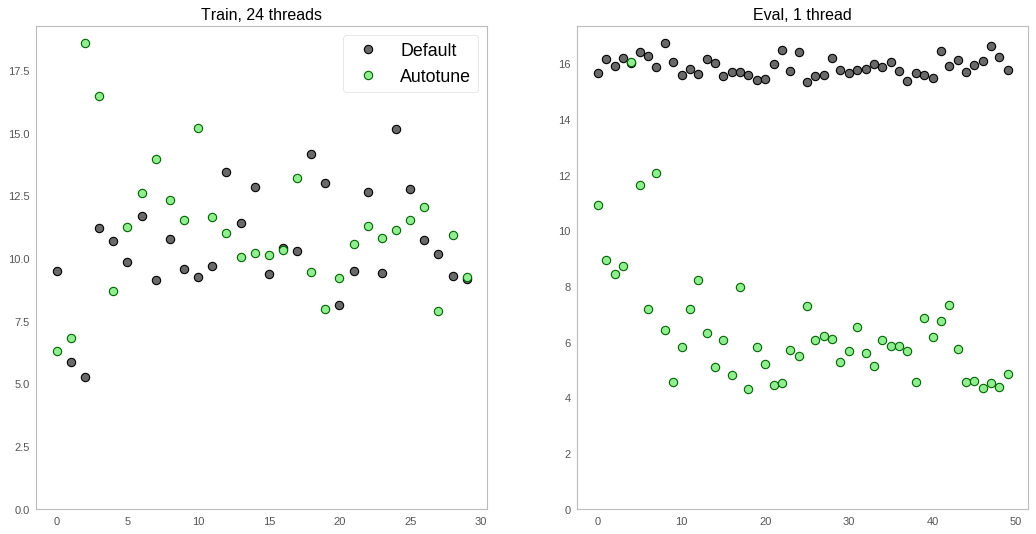

In [945]:
results = {
    "train": {'on': [6.32338359951973, 6.832711614668369, 18.60069932974875, 16.49581429362297, 8.711452152580023, 11.272044019773602, 12.612014124169946, 13.980760123580694, 12.334077952429652, 11.52111380174756, 15.222598534077406, 11.652750546112657, 11.000139316543937, 10.058128783479333, 10.230150859802961, 10.129698272794485, 10.333615962415934, 13.228304855525494, 9.443744784221053, 8.001407073810697, 9.22523501701653, 10.588979452848434, 11.315618228167295, 10.805446058511734, 11.136492235586047, 11.548809826374054, 12.071098675951362, 7.907813288271427, 10.922233808785677, 9.275490714237094], 'off': [9.516643807291985, 5.871150724589825, 5.293392222374678, 11.204403372481465, 10.704043908044696, 9.861342422664165, 11.694464668631554, 9.156909247860312, 10.768342295661569, 9.593544766306877, 9.269026705995202, 9.70611765421927, 13.435154367238283, 11.435638485476375, 12.855011822655797, 9.396968798711896, 10.439599057659507, 10.294329134747386, 14.157681128010154, 13.00435871258378, 8.162989458069205, 9.507570734247565, 12.645793732255697, 9.406687676906586, 15.152019644156098, 12.761871373280883, 10.718901673331857, 10.200512196868658, 9.321827910840511, 9.192939724773169]},
    "eval": {'on': [10.930059306323528, 8.956846419721842, 8.436149718239903, 8.742813112214208, 16.052651518955827, 11.63891851902008, 7.1731539480388165, 12.089015562087297, 6.44532223790884, 4.579590734094381, 5.830288145691156, 7.197322398424149, 8.224624941125512, 6.329395396634936, 5.118049740791321, 6.090900087729096, 4.818571005016565, 7.9798959121108055, 4.323963794857264, 5.8281972669065, 5.207153793424368, 4.4747599847614765, 4.526509735733271, 5.701147524639964, 5.493599601089954, 7.301064450293779, 6.086138883605599, 6.221767073497176, 6.1163721196353436, 5.28359092772007, 5.668452816084027, 6.534925144165754, 5.59965118765831, 5.127083361148834, 6.088446091860533, 5.8549735732376575, 5.8531693816185, 5.682587107643485, 4.586189629510045, 6.865966076031327, 6.178364556282759, 6.752120604738593, 7.340773060917854, 5.751108556985855, 4.569132547825575, 4.604225035756826, 4.344323266297579, 4.52432900108397, 4.393829017877579, 4.854004113003612], 'off': [15.672365628182888, 16.175664709880948, 15.91363862529397, 16.207183809950948, 16.021907275542617, 16.409830018877983, 16.257860207930207, 15.867080891504884, 16.72289344482124, 16.04790525138378, 15.606782380491495, 15.80397580191493, 15.611900843679905, 16.152451172471046, 16.034524608403444, 15.561170561239123, 15.699980080127716, 15.713713064789772, 15.597672427073121, 15.411773407831788, 15.430980129167438, 15.990952456369996, 16.478876112028956, 15.719480840489268, 16.40807595476508, 15.335999658331275, 15.537071529775858, 15.594635806977749, 16.1912619844079, 15.753775062039495, 15.667044594883919, 15.753267515450716, 15.794186955317855, 15.966040030121803, 15.88032771833241, 16.051528306677938, 15.730509938672185, 15.361458253115416, 15.6662676371634, 15.601589743047953, 15.477144610136747, 16.464284550398588, 15.908536944538355, 16.122691934928298, 15.689696904271841, 15.962985584512353, 16.091827942058444, 16.617670573294163, 16.236254626885056, 15.785995664075017]},
}

fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.grid(False)
for i, kwargs in enumerate([NON_AUTOTUNE_MARKER_KWARGS, AUTOTUNE_MARKER_KWARGS]):
    key = "on" if i else "off"

    plt.subplot(1, 2, 1)
    plt.grid(False)
    
    y = results["train"][key]
    plt.plot(y, ".", markersize=15, **kwargs)
    plt.title("Train, 24 threads")
    plt.legend(["Default", "Autotune"], fontsize=16)
    
    plt.subplot(1, 2, 2)
    plt.grid(False)

    y = results["eval"][key]
    plt.plot(y, ".", markersize=15, **kwargs)
    plt.title("Eval, 1 thread")

plt.subplot(1, 2, 1).set_ylim(bottom=0)
plt.subplot(1, 2, 2).set_ylim(bottom=0)

In [802]:
pattern = re.compile(r"([a-zA-Z]+)\s+\((.+)\)\s+([a-zA-Z_0-9]+)\s+([0-9]+)")
raw_results = collections.defaultdict(list)
with open("/tmp/contextual_results.txt", "rt") as f:
    for l in f:
        l = l.strip()
        if not pattern.match(l):
            continue
        
        _, features, choice, delta_ns = pattern.match(l).groups()
        delta_ns = int(delta_ns)
        features = [int(i.strip()) for i in (" ,".join(features.split("    ,")[1:])).split(",")]
        batch_size, c_in, image_h, image_w, _, _, kernel_h, kernel_w, _, c_out, out_h, out_w, _, num_threads = features
        raw_results[(choice, batch_size, c_in, c_out, image_h, image_w, kernel_h, kernel_w, num_threads)].append(delta_ns)
        
results = {k: np.mean(v) for k, v in raw_results.items()}


In [803]:
print(sum(len(v) for v in raw_results.values()))
print(len(results))

5472278
823497


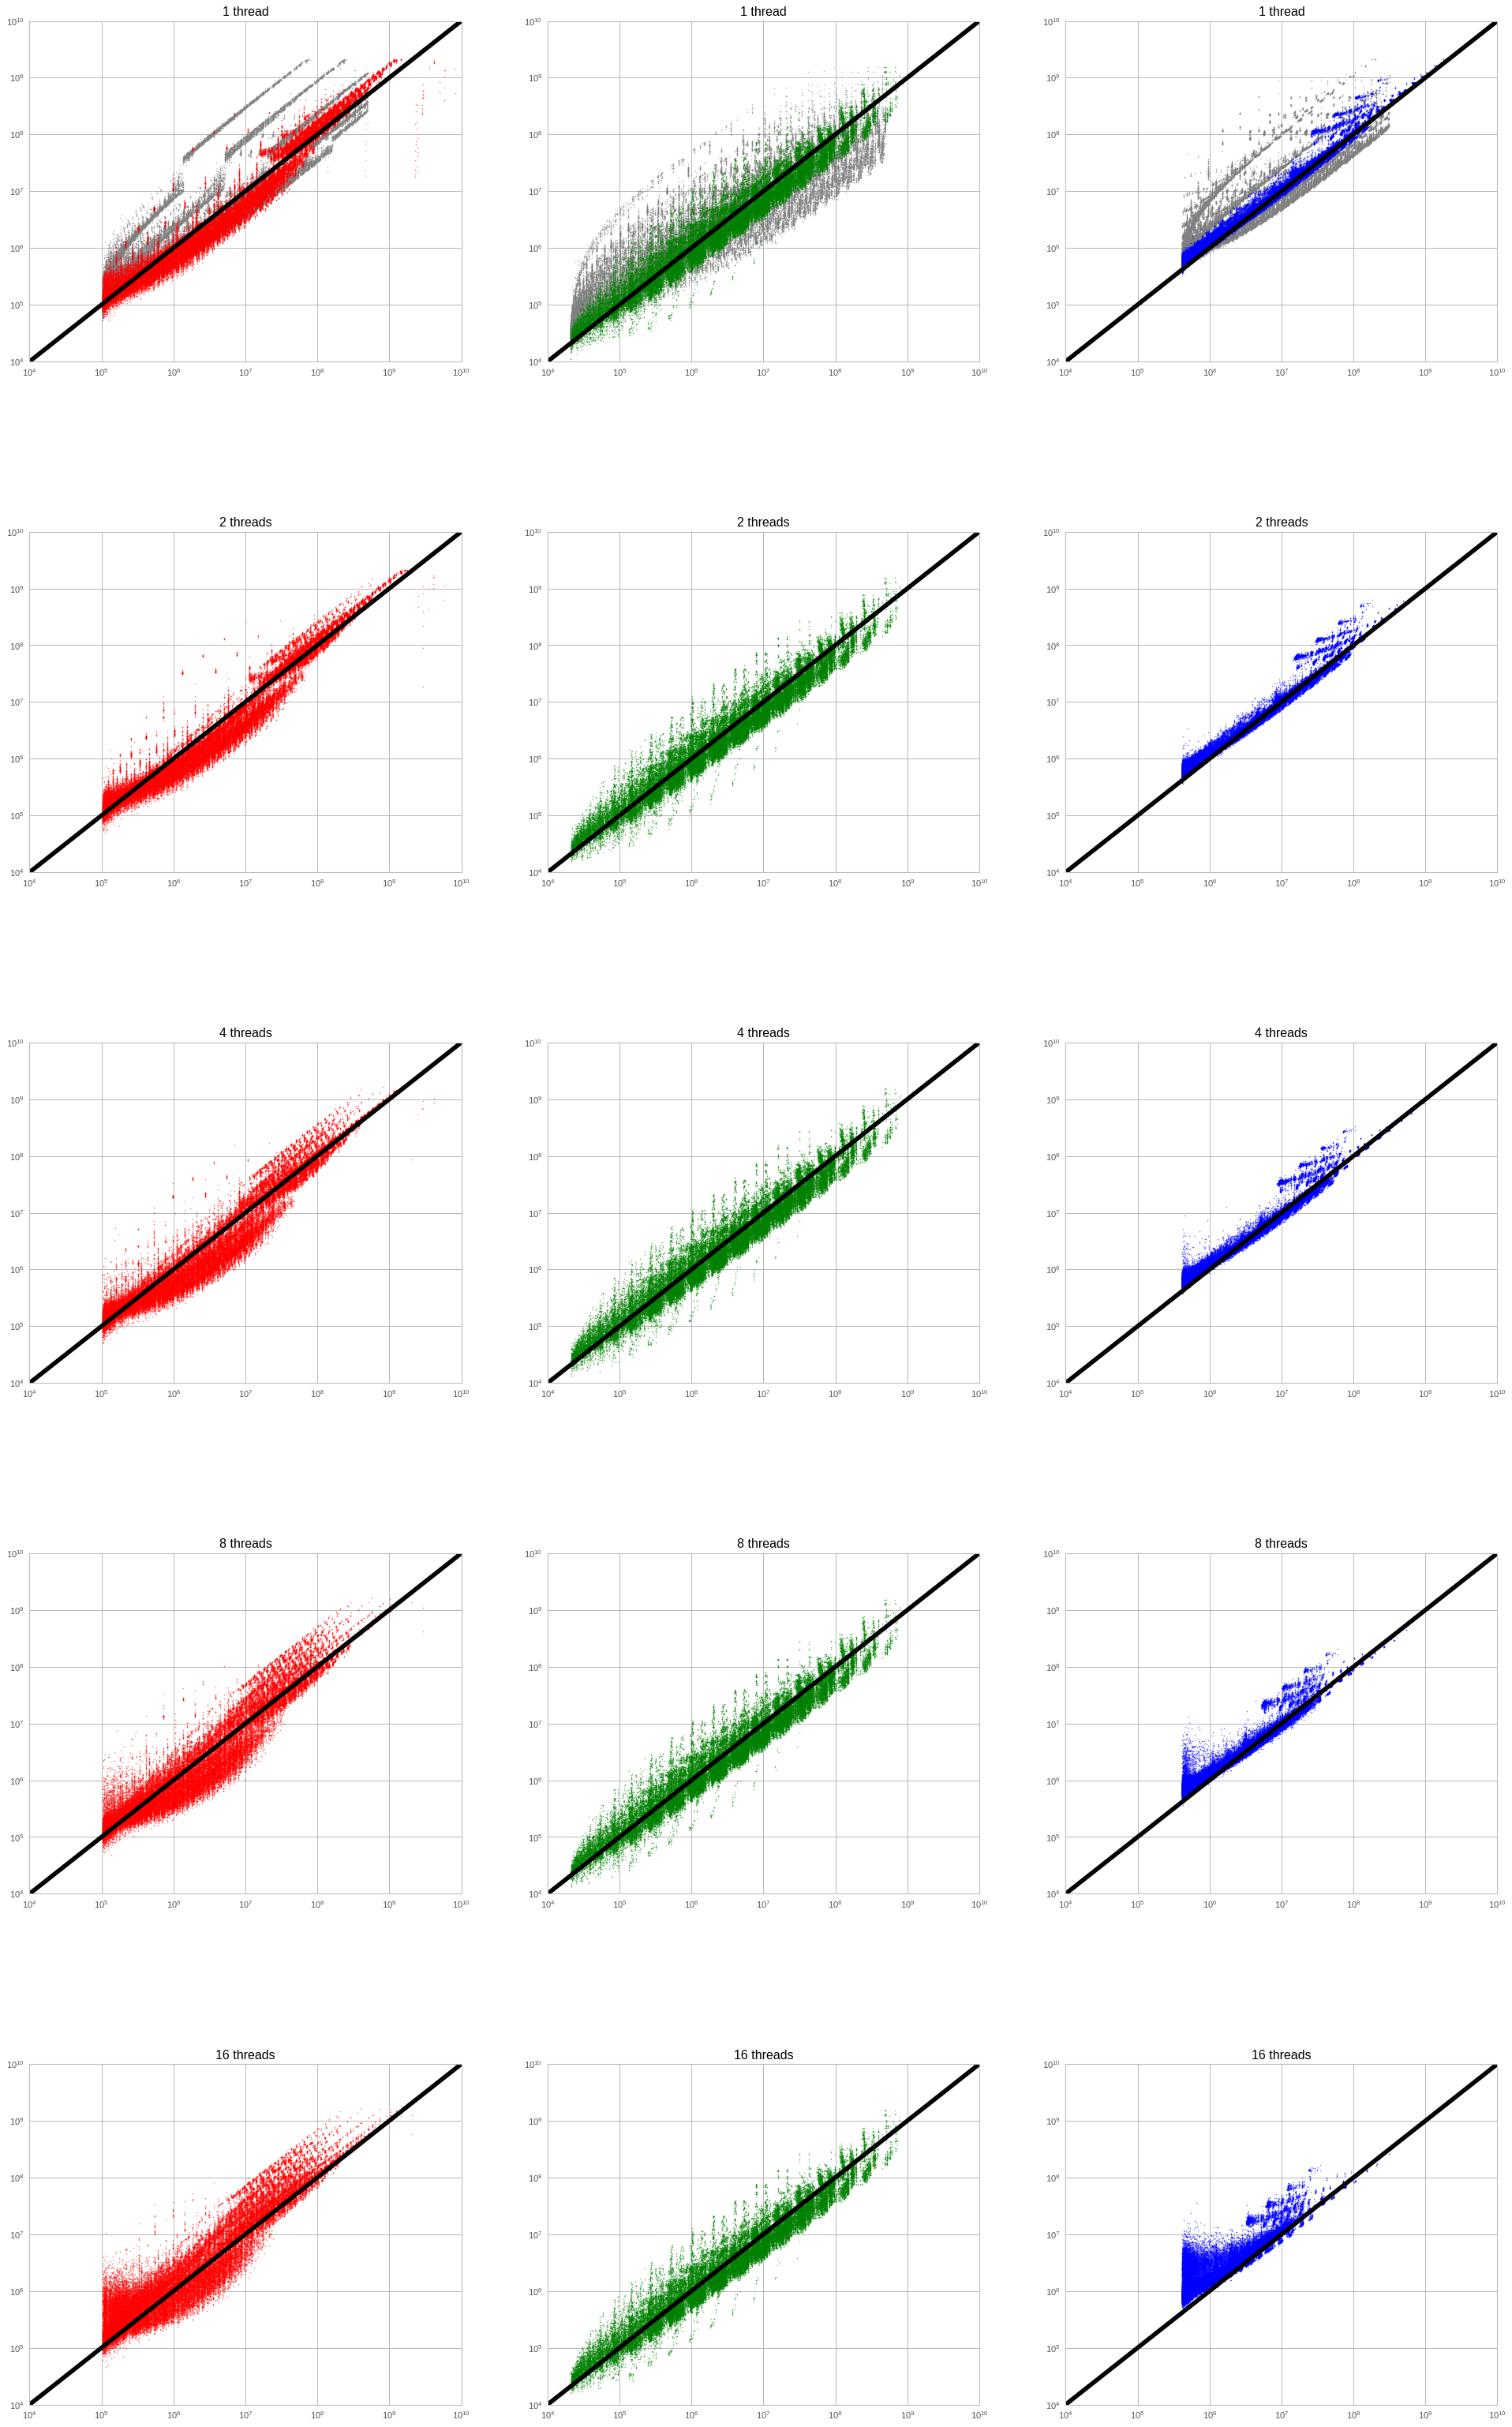

In [804]:
results_by_choice = collections.defaultdict(dict)
for (choice, *f, num_threads), t in results.items():
    results_by_choice[(choice, num_threads)][tuple(f)] = t
    
    
thread_counts = sorted({num_threads for _, num_threads in results_by_choice.keys()})
impl_to_color = {
    "Conv2D_Native": "r",
    "Conv2D_NNPack": "g",
    "Conv2D_MKL": "b",
}
implementations = list(impl_to_color.keys())

limits = {}
for num_threads in thread_counts:
    all_times = []
    for impl in implementations:
        all_times.extend(results_by_choice[(impl, num_threads)].values())
    limits[num_threads] = (
        10 ** np.floor(np.log10(np.min(all_times))),
        10 ** np.ceil(np.log10(np.max(all_times))),
    )

    
im2col_coeff = {
    "Conv2D_Native": 4 / 16,
    "Conv2D_NNPack": 0,
    "Conv2D_MKL": 0,
}

layout_coeff = {
    "Conv2D_Native": 0,
    "Conv2D_NNPack": 8 / 16,
    "Conv2D_MKL": 4 / 16,
}


overhead = {
    "Conv2D_Native": 250_000,
    "Conv2D_NNPack":  50_000,
    "Conv2D_MKL": 1_000_000,
}

cpu_ghz = 2.4
vector_size = 16
work_to_time = {
    "Conv2D_Native": 1 / 4,
    "Conv2D_NNPack": 1 / 4,
    "Conv2D_MKL": 1 / 2.5,
}
amdahl_thread_factor = {
    "Conv2D_Native": 0.5,
    "Conv2D_NNPack": 0,
    "Conv2D_MKL": 0.8,
}

cost_estimates = collections.defaultdict(list)

def scale_work_by_threads(work, num_threads):
    grain_size = 32000

    work_per_pass = grain_size * num_threads
    complete_passes = np.floor(work / work_per_pass)
    return (
        # Work sharded to multiple workers
        complete_passes * grain_size + 
        
        # remainder, which must be handled by a single worker.
        work - complete_passes * work_per_pass
    )


fig = plt.figure(figsize=(30, 50), dpi=80, facecolor='w', edgecolor='k')
for subplot_ind, (choice, color) in enumerate(impl_to_color.items()):
    for thread_ind, num_threads in enumerate(thread_counts):
        x = []
        y = []
        f_t = []
        naive_roofline = []
        for f, t in results_by_choice[(choice, num_threads)].items():
            batch_size, c_in, c_out, image_h, image_w, kernel_h, kernel_w = f
            
            out_h = image_h - kernel_h + 1
            out_w = image_w - kernel_w + 1

            effective_inner_size = max(vector_size, c_in * kernel_h * kernel_w)
            effective_c_out = max(c_out, vector_size) if choice == "Conv2D_MKL" else c_out
            
            factor0 = 1 / (min(out_h * out_w, effective_inner_size, effective_c_out)**0.2)
            compute_roofline = batch_size * out_h * out_w * effective_c_out * effective_inner_size * factor0
            
            im2col_roofline = 4 * batch_size * image_h * image_w * kernel_h * kernel_w * c_in
            if kernel_h == 1 and kernel_w == 1:
                im2col_roofline = 0
                
            layout_transform = 4 * (
                batch_size * c_in * image_h * image_w + 
                batch_size * c_out * out_h * out_w +
                c_in * c_out * kernel_h * kernel_w
            )
                
            if choice == "Conv2D_NNPack":
                if (kernel_h, kernel_w) == (1, 1):
                    # Direct convolution
                    pass
                elif (kernel_h, kernel_w) == (3, 3):
                    compute_roofline = batch_size * c_out * c_in * max(out_h * out_w, 64) * 2  # Winograd
                elif 8 >= kernel_h > 1 or kernel_w > 1:
                    compute_roofline = batch_size * c_out * c_in * max(out_h * out_w, 64) * 4  # FFT
                else:
                    # Indirect convolution
                    pass
    
            effective_num_threads = num_threads ** amdahl_thread_factor[choice]
            compute_roofline = scale_work_by_threads(compute_roofline, effective_num_threads)
            im2col_roofline = scale_work_by_threads(im2col_roofline, effective_num_threads)
            layout_transform = scale_work_by_threads(layout_transform, effective_num_threads)
                        
            x.append((
                compute_roofline,
                im2col_roofline,
                layout_transform
            ))
            y.append(t)
            f_t.append((f, t))
            naive_roofline.append(batch_size * out_h * out_w * c_out * c_in * kernel_h * kernel_w)
        x = np.array(x)
        y = np.array(y)
        
        cost = ((x[:, 0] / vector_size + im2col_coeff[choice] * x[:, 1] + layout_coeff[choice] * x[:, 2])  / work_to_time[choice] + overhead[choice]) / cpu_ghz
        
        sort_ind = np.argsort(cost)
        f_t = [f_t[i] for i in sort_ind]
        naive_roofline = (np.array(naive_roofline)[sort_ind]/ vector_size / work_to_time[choice] + overhead[choice]) / cpu_ghz
        x = x[sort_ind, :]
        cost = cost[sort_ind]
        y = y[sort_ind]
        
        for i, (f, t) in enumerate(f_t):
            cost_estimates[f + (num_threads,)].append((choice, cost[i], t))
        
        discrete_cost = np.logspace(np.log10(cost[0]), np.log10(cost[-1]) * 1.05, 500)
        ind = 0
        group_indices = [[]]
        for i, c in enumerate(cost):
            while c >= discrete_cost[ind + 1]:
                ind += 1
                group_indices.append([])
            cost_indices.append(ind)
            group_indices[-1].append(i)
            
#         variation_index, variation = -1, 0
#         for i, indices in enumerate(group_indices):
#             if not indices:
#                 continue
#             times = [y[i] for i in indices]
#             if np.max(times) / np.min(times) > variation:
#                 variation = np.max(times) / np.min(times)
#                 variation_index = i

        
        f_t_slice = [f_t[i] for i in group_indices[variation_index]]
        f_t_slice.sort(key=lambda x: x[1])
#         print(len(f_t_slice), discrete_cost[variation_index])
#         for features, t in f_t_slice:
#             print(f"{t / 1e3:10.1f}{'':>10}" + "  ".join([f"{fi:>8}" for fi in features]))
#         print()
        
        x_group, y_group = [], []
        for i, ind in enumerate(group_indices):
            if len(ind) < 5:
                continue
            x_group.append(np.mean([discrete_cost[i], discrete_cost[i + 1]]))
            y_group.append(np.mean([y[j] for j in ind]))

        plt.subplot(len(thread_counts), 3, subplot_ind + 1 + 3 * thread_ind)
        if num_threads == 1:
            plt.loglog(naive_roofline, y, ".", color="grey", markersize=0.5)
        plt.loglog(cost, y, ".", color=color, markersize=0.5)
#         plt.loglog(
#             [cost[i] / work_to_time[choice] for i in group_indices[variation_index]],
#             [y[i] for i in group_indices[variation_index]],
#             ".k"
#         )
        plt.loglog(limits[num_threads], limits[num_threads], "k", linewidth=5)
        plt.xlim(*limits[num_threads])
        plt.ylim(*limits[num_threads])
        plt.title(f"{num_threads} thread{'s' if num_threads > 1 else ''}")
        
#         break
#     break
    

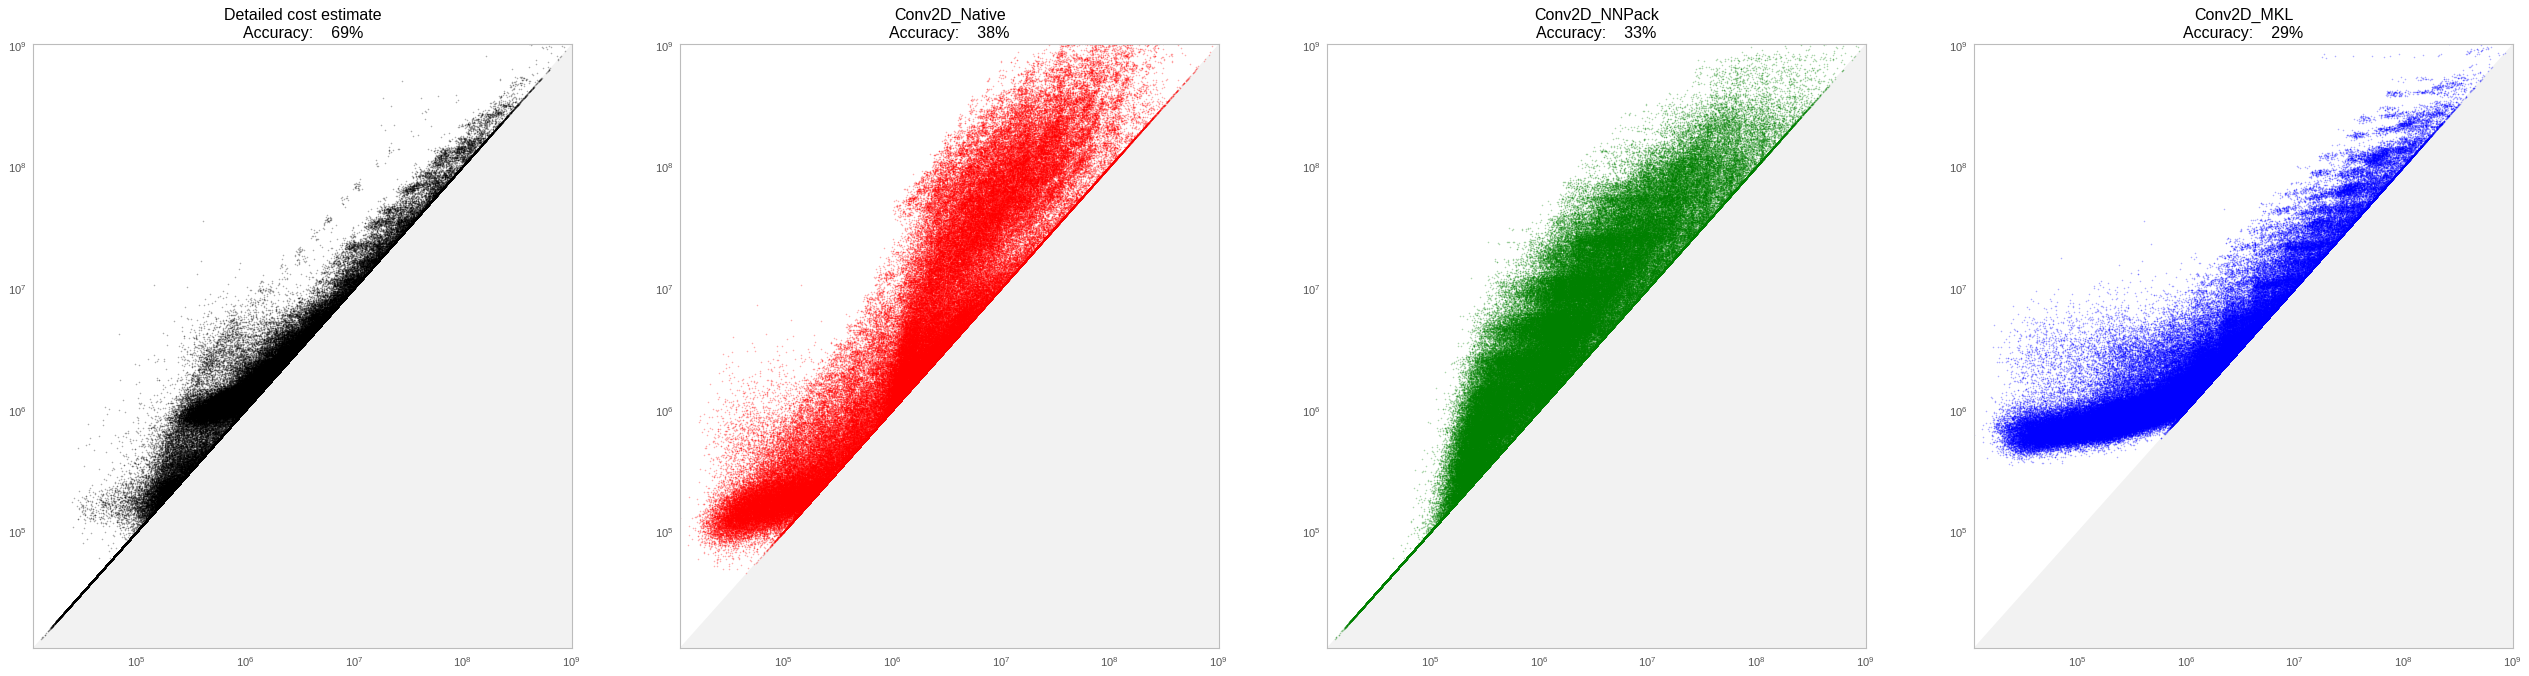

In [805]:

correct = 0
total = 0

x = []
y = []
y_choice = {
    "Conv2D_Native": [],
    "Conv2D_NNPack": [],
    "Conv2D_MKL": [],
}
choice_best = {
    "Conv2D_Native": 0,
    "Conv2D_NNPack": 0,
    "Conv2D_MKL": 0,
}
np.random.seed(0)
for i, (k, v) in enumerate(cost_estimates.items()):
    if len(v) != 3:
        continue

    v_by_pred = sorted(v, key=lambda x: x[1])
    v_by_actual = sorted(v, key=lambda x: x[2])
    
    total += 1
    correct += (v_by_pred[0][0] == v_by_actual[0][0])
    choice_best[v_by_actual[0][0]] += 1
    
    x.append(v_by_actual[0][2])
    y.append(v_by_pred[0][2])
    for choice, _, t in v:
        y_choice[choice].append(t)


limits = [min(x), max(x)]

def fmt_plot():
    xy_exclude = np.logspace(np.log10(limits[0]), np.log10(limits[1]), 100)
    plt.fill_between(xy_exclude, [0 for _ in xy_exclude], xy_exclude, facecolor="gray", alpha=0.1)
    plt.xlim(*limits)
    plt.ylim(*limits)
    plt.grid(False)

fig = plt.figure(figsize=(40, 10), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 4, 1)
plt.loglog(x, y, ".", markersize=0.3, color="k")
plt.title(f"Detailed cost estimate\nAccuracy: {correct / total * 100:5.0f}%")
fmt_plot()

for subplot_ind, (choice, color) in enumerate(impl_to_color.items()):
    plt.subplot(1, 4, 2 + subplot_ind)
    plt.loglog(x, y_choice[choice], ".", markersize=0.3, color=color)
    plt.title(f"{choice}\nAccuracy: {choice_best[choice] / total * 100:5.0f}%")
    fmt_plot()


In [787]:
cost_estimates[(1, 128, 128, 2, 2, 3, 3, 1)]
for k, v in cost_estimates.items():
    batch_size, c_in, c_out, image_h, image_w, kernel_h, kernel_w, num_threads = k
    if batch_size > 1 or c_in < 64 or c_out < 64 or image_h > 8 or image_w > 8 or kernel_h != 3 or kernel_w != 3 or num_threads > 1 or not v:
        continue
    print(k)
    print(v)
    print()
print()
print(cost_estimates[(1, 128, 128, 4, 4, 3, 3, 1)])

(1, 64, 64, 4, 4, 3, 3, 1)
[('Conv2D_Native', 131167.36989746653, 167459.5), ('Conv2D_NNPack', 151393.33333333334, 333692.4), ('Conv2D_MKL', 463675.4395192499, 789450.0)]

(1, 64, 128, 4, 4, 3, 3, 1)
[('Conv2D_Native', 142808.07312826638, 164971.33333333334), ('Conv2D_NNPack', 278540.0, 683051.5), ('Conv2D_MKL', 509617.5457051665, 783690.6666666666)]

(1, 128, 64, 4, 4, 3, 3, 1)
[('Conv2D_Native', 158168.07312826638, 175909.66666666666), ('Conv2D_NNPack', 281100.0, 632874.25), ('Conv2D_MKL', 510417.5457051665, 821380.75)]

(1, 128, 128, 4, 4, 3, 3, 1)
[('Conv2D_Native', 181449.4795898661, 252820.57142857142), ('Conv2D_NNPack', 534540.0, 1272148.75), ('Conv2D_MKL', 602035.091410333, 866557.7)]


[('Conv2D_Native', 181449.4795898661, 252820.57142857142), ('Conv2D_NNPack', 534540.0, 1272148.75), ('Conv2D_MKL', 602035.091410333, 866557.7)]
